# UB DataScience: Complex networks
### David Solans & Gerard Martinez

In [166]:

import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools
from networkx.algorithms import community
import collections
import numpy as np
import pickle
import operator
import folium

plt.style.use('seaborn')

%matplotlib inline

## Loading data

In [167]:
G_transport = nx.read_edgelist("barcelona_transport.edgelist", create_using = nx.Graph(), nodetype = int)
G_bus = nx.read_edgelist("barcelona_bus.edgelist", create_using = nx.Graph(), nodetype = int)
G_metro = nx.read_edgelist("barcelona_metro.edgelist", create_using = nx.Graph(), nodetype = int)

In [168]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [169]:
#Quick snapshot of the Network
print(nx.info(G_transport))

Name: 
Type: Graph
Number of nodes: 2496
Number of edges: 3295
Average degree:   2.6402


In [170]:
# Average separation of nodes for transport graph
node_distances = []
for g in nx.connected_component_subgraphs(G_transport): 
    node_distances.append(nx.average_shortest_path_length(g)) 

    
print("Average separation of nodes: {}".format(np.mean(node_distances)))

Average separation of nodes: 8.71959282183631


In [171]:
#Quick snapshot of the Network
print(nx.info(G_bus))

Name: 
Type: Graph
Number of nodes: 2469
Number of edges: 3127
Average degree:   2.5330


In [172]:
# Average separation of nodes in metro
node_distances_metro = []
for g in nx.connected_component_subgraphs(G_metro): 
    node_distances_metro.append(nx.average_shortest_path_length(g)) 

    
print("Average separation of nodes in metro network: {}".format(np.mean(node_distances_metro)))

Average separation of nodes in metro network: 11.67776228651098


In [173]:
#Quick snapshot of the Network
print(nx.info(G_metro))

Name: 
Type: Graph
Number of nodes: 152
Number of edges: 168
Average degree:   2.2105


In [174]:
# Average separation of nodes in bus
node_distances_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_distances_bus.append(nx.average_shortest_path_length(g)) 

    
print("Average separation of nodes in bus network: {}".format(np.mean(node_distances_bus)))

Average separation of nodes in bus network: 9.731034826202404


### Selected network: BUS

We've selected the bus network because it's large enough and it's not conected to the metro network in the source where the data is obtained from

## 01: Matrices

### Exploratory Data Analysis

In [175]:
nodes = list(G_bus.nodes())

In [176]:
bus_stations_properties = load_obj("bus_stations_properties")

In [177]:
bus_stops_coords = []
bus_stops_names = []
bus_stops_coords_lats = []
bus_stops_coords_lngs = []
for bs in bus_stations_properties.values():
    bus_stops_coords.append([bs['lat'], bs['lon']])
    bus_stops_coords_lats.append(float(bs['lat']))
    bus_stops_coords_lngs.append(float(bs['lon']))
    bus_stops_names.append(bs['street_name'])

In [178]:
bus_stops_coords_lats[0]

41.3985182

In [179]:
bus_stops_names[:10]

['Almogàvers-Àvila',
 'Av Icària-Bogatell',
 'València-Muntaner',
 'Mallorca-Aribau',
 'Universitat Central',
 'Pl Universitat-Balmes',
 'Pl Universitat-Aribau',
 'Pl de Carles Buïgas',
 'Josep Soldevila - Doctor Santponç',
 'Josep Soldevila - Sant Adrià']

In [180]:
## Plotting the bus stops on a map
map_osm = folium.Map(location=[41.387084, 2.169792], zoom_start=12)
    
for lng, lat in zip(bus_stops_coords_lngs,
                         bus_stops_coords_lats):
    folium.Circle([lat, lng], radius=50).add_to(map_osm)
    
map_osm

In [181]:
bus_edges_list = []
for e in G_bus.edges():
    l = []
    if(e[0] in bus_stations_properties and e[1] in bus_stations_properties):
        l.append([float(bus_stations_properties[e[0]]['lat']), float(bus_stations_properties[e[0]]['lon'])])
        l.append([float(bus_stations_properties[e[1]]['lat']), float(bus_stations_properties[e[1]]['lon'])])
        bus_edges_list.append(l)
bus_edges_list[0]

[[41.3857139, 2.1946319], [41.3845874, 2.1954927]]

In [182]:
#Check: https://github.com/python-visualization/folium/blob/master/examples/Polyline_text_path.ipynb
map_osm = folium.Map(location=[41.387084, 2.169792], zoom_start=12)
 
"""    
for lng, lat in zip(bus_stops_coords_lngs,
                         bus_stops_coords_lats):
    folium.Circle([lat, lng], radius=50).add_to(map_osm)
"""
    

for e in bus_edges_list:
    folium.PolyLine(e,  weight=1).add_to(map_osm)
        
map_osm

In [183]:
#Auxiliary function to plot color categories
def plotNetwork(G, node_categories, colormap="jet", pos=None):
    plt.axis("off")
    if pos == None:
        pos = spring_pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos = pos, cmap = plt.get_cmap(colormap), node_color = node_categories, node_size = 35, with_labels = False)

In [184]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(G_bus)

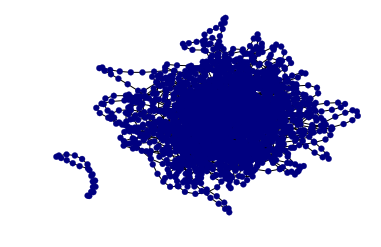

In [185]:
plotNetwork(G_bus, [0]*len(nodes),pos=spring_pos)

# --------- Week 2 --------- 

## 02: Local characterization

In [186]:
kantx_centrality_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    kantx_centrality_bus.append(nx.katz_centrality(g)) 

#print("Centers per connected component: {}".format(center_bus))

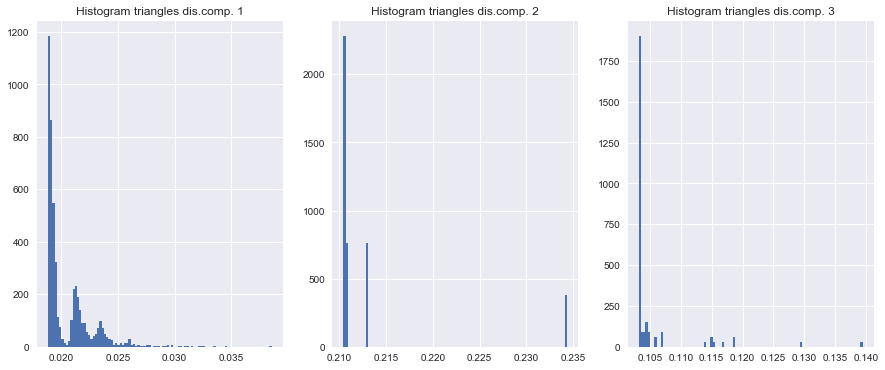

In [187]:
f, axarr = plt.subplots(1, 3,figsize=(15,6))
axarr[0].hist(list(kantx_centrality_bus[0].values()), bins=100,normed=True)
#axarr[0].plot(lnspc, pdf_gamma, label="f(λ) = λ * e(-λ* x)",color='red') 
axarr[1].hist(list(kantx_centrality_bus[1].values()), bins=100,normed=True)
axarr[2].hist(list(kantx_centrality_bus[2].values()), bins=100,normed=True)
axarr[0].set_title('Histogram triangles dis.comp. 1')
axarr[1].set_title('Histogram triangles dis.comp. 2')
axarr[2].set_title('Histogram triangles dis.comp. 3')
#axarr[0].legend(loc='upper right')
#axarr[1].legend(loc='upper right')
#axarr[2].legend(loc='upper right')
plt.show()

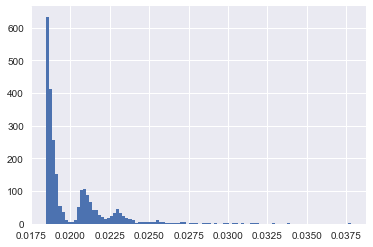

In [188]:
# Kantz centrality
kantx_centrality = nx.katz_centrality(G_bus)
plt.hist(list(kantx_centrality.values()), bins=100)  # histogram with 100 bins
plt.show()

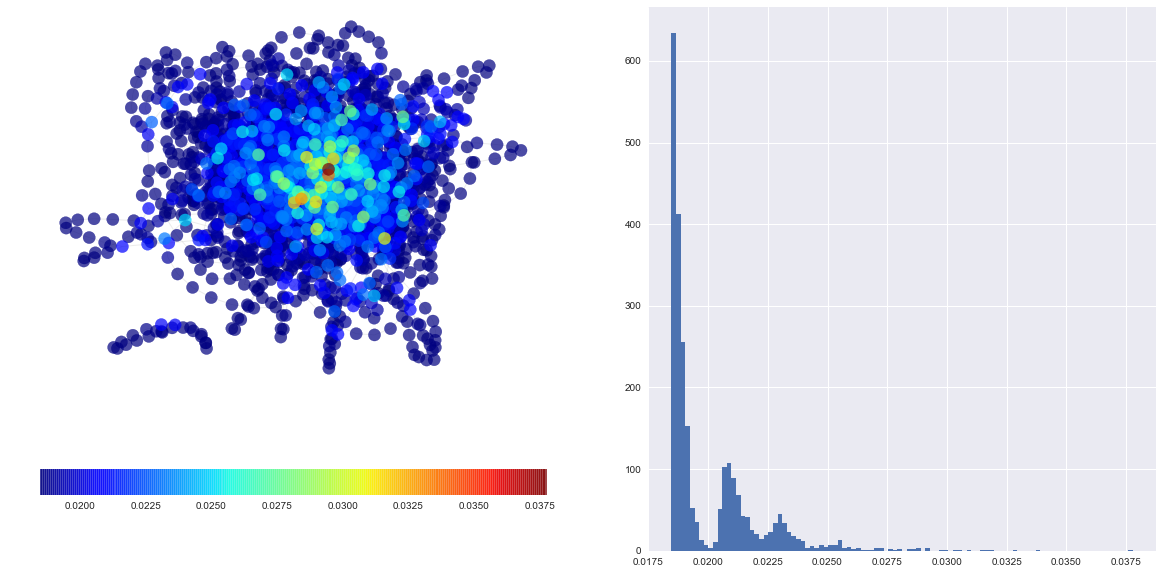

In [189]:
pos = nx.spring_layout(G_bus)
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.axis('off')
nx.draw_networkx_edges(G_bus, pos=pos, edge_color='#c1c1c1', alpha=.3)
scores = dict(kantx_centrality)
nodelist = sorted(G_bus.nodes(), key=lambda n: scores[n])
ncolor = np.asarray([scores[n] for n in nodelist])
nodes = nx.draw_networkx_nodes(G_bus, nodelist=nodelist, pos=pos, node_size=150, cmap=plt.cm.jet, node_color=ncolor, alpha=0.7)
plt.colorbar(nodes, cmap=plt.cm.jet, orientation='horizontal')

plt.subplot(122)
score_array = np.array(list(scores.values()))
plt.hist(score_array,bins=100)
plt.show()

In [ ]:
# Comunicability
communicability = nx.communicability(G_bus)

## 03 - Macroscale

#### Elements disconnected components

We identify how many disconnected components components we plot the results in a map.

In [191]:
## We build a list of 3 list that contains the nodes for each of the disconnected components
interest_edges = []
for i in nx.connected_component_subgraphs(G_bus):
    interest_edges.append(i.nodes())

compt=0
for i in interest_edges:
    print('Number of nodes disconnected component',compt+1)
    print(len(i))
    compt+=1;

Number of nodes disconnected component 1
2357
Number of nodes disconnected component 2
22
Number of nodes disconnected component 3
90


In [192]:
##Nodes in the disconnected component 2 (something strange happens with nodes 3014 anf 2931)#
#print('DISCONNEX COMPONENT 2')
#for i in interest_edges[1]:
#    print(i)
#    if i!=3014 and i!=2931:
#        print(bus_stations_properties[i]['street_name'])

Let's store the latitud and longitud values for the nodes of the disconnected components 1,2,3

In [193]:
component1=[]
bus_stops_coords_lngs_component1=[]
bus_stops_coords_lats_components1=[]
for i in interest_edges[0]:
    try:
        bus_stops_coords_lngs_component1.append(float(bus_stations_properties[i]['lon']))
        bus_stops_coords_lats_components1.append(float(bus_stations_properties[i]['lat']))
    except KeyError:
        pass
    
component2=[]
bus_stops_coords_lngs_component2=[]
bus_stops_coords_lats_components2=[]
for i in interest_edges[1]:
    if i!=3014 and i!=2931:
        bus_stops_coords_lngs_component2.append(float(bus_stations_properties[i]['lon']))
        bus_stops_coords_lats_components2.append(float(bus_stations_properties[i]['lat']))

#NAMES Disconnected component 3
#print('DISCONNEX COMPONENT 3')
#for i in interest_edges[2]:
#    print(i)
#    if i!=2080 and i!=2082 and i!=2109:
#        print(bus_stations_properties[i]['street_name'])

component3=[]
bus_stops_coords_lngs_component3=[]
bus_stops_coords_lats_components3=[]
for i in interest_edges[2]:
    if i!=2080 and i!=2082 and i!=2109:
        bus_stops_coords_lngs_component3.append(float(bus_stations_properties[i]['lon']))
        bus_stops_coords_lats_components3.append(float(bus_stations_properties[i]['lat']))

In [194]:
## Plotting the bus stops on a map
map_osm = folium.Map(location=[41.387084, 2.169792], zoom_start=12)


for lng, lat in zip(bus_stops_coords_lngs_component1,
                         bus_stops_coords_lats_components1):
    folium.Circle([lat, lng], radius=50, color='#27cc53').add_to(map_osm)


for lng, lat in zip(bus_stops_coords_lngs_component2,
                         bus_stops_coords_lats_components2):
    folium.Circle([lat, lng], radius=50, color='#3186cc').add_to(map_osm)
    ##Blue dots is the disconnected component 2
    
for lng, lat in zip(bus_stops_coords_lngs_component3,
                         bus_stops_coords_lats_components3):
    folium.Circle([lat, lng], radius=50,color='#f40101').add_to(map_osm)
    ##Red dots is the disconnected component 3
    
map_osm

#### Shortest path

Return the average shortest path length between nodes.

In [195]:
# Mean shortest path
# Average separation of nodes in bus
# nx.average_shortest_path_length(G)

node_distances_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_distances_bus.append(nx.average_shortest_path_length(g)) 


print("Average separation per connected component: {}".format(node_distances_bus))
print("Average separation of nodes in bus network: {}".format(np.mean(node_distances_bus)))

Average separation per connected component: [14.307380464793308, 4.658008658008658, 10.227715355805243]
Average separation of nodes in bus network: 9.731034826202404


#### Diameter

In [196]:
#Diameter
#nx.diameter(G)

node_diametres_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_diametres_bus.append(nx.diameter(g)) 

   
print("Diametre per connected component: {}".format(node_diametres_bus))
print("Average diameter in bus network: {}".format(np.mean(node_diametres_bus)))



Diametre per connected component: [36, 11, 25]
Average diameter in bus network: 24.0


#### Radius

In [197]:
node_radius_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_radius_bus.append(nx.radius(g)) 

   
print("Diametre per connected component: {}".format(node_radius_bus))
print("Average diameter in bus network: {}".format(np.mean(node_radius_bus)))

Diametre per connected component: [20, 6, 14]
Average diameter in bus network: 13.333333333333334


#### Center

The center is the set of nodes with eccentricity (The eccentricity of a node v is the maximum distance from v to
all other nodes in G) equal to radius.

In [198]:
center_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    center_bus.append(nx.center(g)) 

print("Centers per connected component: {}".format(center_bus))

Centers per connected component: [[149, 1067, 1069, 1081, 1246, 2833], [1804, 1816, 2149, 501], [2573, 2074, 2075, 2076, 2209, 3005, 3006]]


In [199]:
component_center1=[]
bus_stops_coords_lngs_component_center1=[]
bus_stops_coords_lats_component_center1=[]
for j in range(0,len(center_bus)): 
    for i in center_bus[j]:
    #if i!=2080 and i!=2082 and i!=2109:
        bus_stops_coords_lngs_component_center1.append(float(bus_stations_properties[i]['lon']))
        bus_stops_coords_lats_component_center1.append(float(bus_stations_properties[i]['lat']))

In [200]:
## Plotting the bus stops on a map
map_osm = folium.Map(location=[41.387084, 2.169792], zoom_start=12)


for lng, lat in zip(bus_stops_coords_lngs_component_center1[0:len(center_bus[0])],
                         bus_stops_coords_lats_component_center1[0:len(center_bus[0])]):
    folium.Circle([lat, lng], radius=50, color='#27cc53').add_to(map_osm)


for lng, lat in zip(bus_stops_coords_lngs_component_center1[len(center_bus[0]):(len(center_bus[0])+len(center_bus[1]))],
                    bus_stops_coords_lats_component_center1[len(center_bus[0]):(len(center_bus[0])+len(center_bus[1]))]):
    folium.Circle([lat, lng], radius=50, color='#3186cc').add_to(map_osm)
    ##Blue dots is the disconnected component 2
    
for lng, lat in zip(bus_stops_coords_lngs_component_center1[(len(center_bus[0])+len(center_bus[1])):],
                    bus_stops_coords_lats_component_center1[(len(center_bus[0])+len(center_bus[1])):]):
    folium.Circle([lat, lng], radius=50,color='#f40101').add_to(map_osm)
    ##Red dots is the disconnected component 3
    
map_osm

Let's identify which are the stations of each disconnected components that are in the center.

In [201]:
compt=0
for i in center_bus:
    print('DISCONNEX COMPONENT',compt+1)
    for j in range(0,len(i)):
        print(bus_stations_properties[i[j]]['street_name'])
    compt+=1;
    print('\n')
        

DISCONNEX COMPONENT 1
Gran Via-Roger de Llúria
Pl Urquinaona-Pau Claris
Metro Urquinaona
Gran Via-Pau Claris
Gran Via-Bruc
Pg de Gràcia-Ronda de Sant Pere


DISCONNEX COMPONENT 2
Camí Vell
Mont d'Orsà
Pl Tibidabo
Colònia Tibidabo


DISCONNEX COMPONENT 3
Ctra de l'Esglèsia-Camí del Faig
Torrent del Rovelló-Camí del Pantá
Torrent del Rovelló-Camí Baix del Mas Sauró
Camí Alt del Mas Sauró-Font Mosen Cinto Verdaguer
Pl de Vallvidrera
Pg del Grèvol
Pg del Grèvol-Camí de Can Castellví




#### Periphery

The periphery is the set of nodes with eccentricity equal to the diameter.

In [202]:
node_periphery_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_periphery_bus.append(nx.periphery(g)) 

   
print("Periphery per connected component: {}".format(node_periphery_bus))
#print("Average diameter in bus network: {}".format(np.mean(node_periphery_bus)))

Periphery per connected component: [[2780, 2781, 3034], [1812, 1820], [2085, 2086, 2299, 2300, 2303]]


In [203]:
component_periphery=[]
bus_stops_coords_lngs_component_periphery=[]
bus_stops_coords_lats_component_periphery=[]
for j in range(0,len(node_periphery_bus)): 
    for i in node_periphery_bus[j]:
        try:
            bus_stops_coords_lngs_component_periphery.append(float(bus_stations_properties[i]['lon']))
            bus_stops_coords_lats_component_periphery.append(float(bus_stations_properties[i]['lat']))
        except KeyError:
            pass

In [204]:
## Plotting the bus stops on a map
map_osm = folium.Map(location=[41.387084, 2.169792], zoom_start=12)


for lng, lat in zip(bus_stops_coords_lngs_component_periphery[0:len(node_periphery_bus[0])],
                         bus_stops_coords_lats_component_periphery[0:len(node_periphery_bus[0])]):
    folium.Circle([lat, lng], radius=50, color='#27cc53').add_to(map_osm)


for lng, lat in zip(bus_stops_coords_lngs_component_periphery[len(node_periphery_bus[0]):(len(node_periphery_bus[0])+len(node_periphery_bus[1]))],
                    bus_stops_coords_lats_component_periphery[len(node_periphery_bus[0]):(len(node_periphery_bus[0])+len(node_periphery_bus[1]))]):
    folium.Circle([lat, lng], radius=50, color='#3186cc').add_to(map_osm)
    ##Blue dots is the disconnected component 2
    
for lng, lat in zip(bus_stops_coords_lngs_component_periphery[(len(node_periphery_bus[0])+len(node_periphery_bus[1])):],
                    bus_stops_coords_lats_component_periphery[(len(node_periphery_bus[0])+len(node_periphery_bus[1])):]):
    folium.Circle([lat, lng], radius=50,color='#f40101').add_to(map_osm)
    ##Red dots is the disconnected component 3
    
map_osm

In [205]:
compt=0
for i in node_periphery_bus:
    print('DISCONNEX COMPONENT',compt+1)
    for j in range(0,len(i)):
        if i[j]!=3034:
            print(bus_stations_properties[i[j]]['street_name'])
    compt+=1;
    print('\n')

DISCONNEX COMPONENT 1
Maurici Vilomara-Penyal
Penyal-Pl Font d'en Fargas


DISCONNEX COMPONENT 2
Parc de la Budellera
Ctra de Vallvidrera-Cruïlla de Carreteres


DISCONNEX COMPONENT 3
Camí Baix del Mas Sauró direcció Mas Guimbau
Torrent del Rovelló direcció Mas Guimbau
Pl de la Tulipa-Satèl·lits
Orellana-Passatge Ossa Major
Orellana




#### Degree distributions

In [206]:
a=nx.degree_histogram(G_bus)
totalnodes=0
for i in range(len(a)):
    totalnodes+=a[i]*i

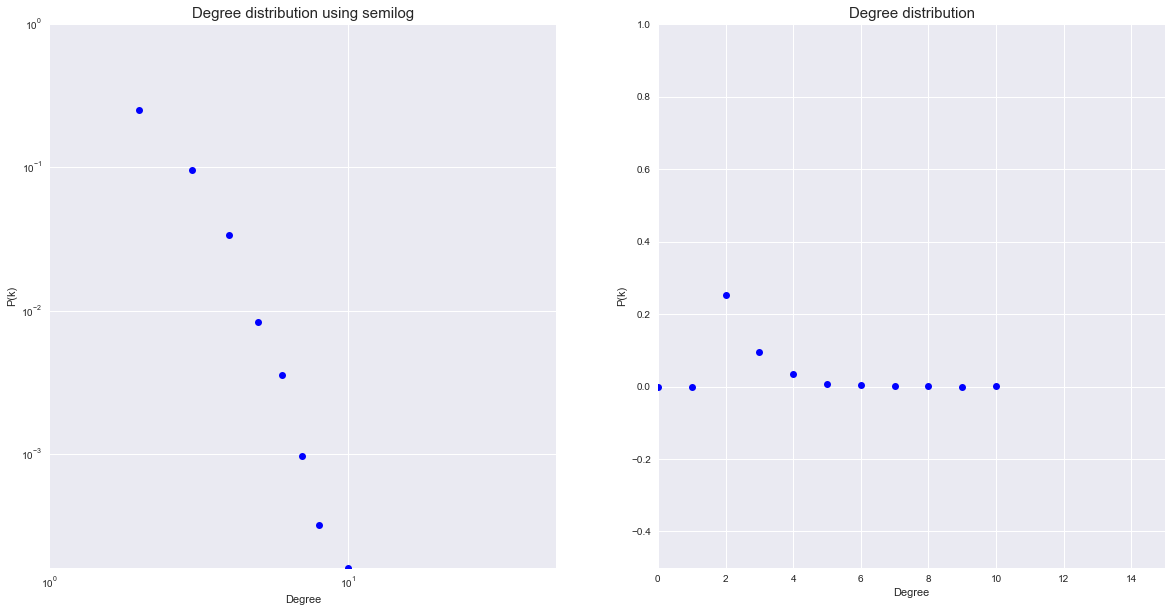

In [207]:
plt.figure(figsize=(20,10))

plt.subplot(121)
distdegree=np.asarray(a)/totalnodes
#b=np.arange(len(a))
plt.plot(distdegree, 'bo')
plt.semilogy()
plt.semilogx()
plt.xlim(0, 50)
plt.ylim(-5, 1)
plt.title('Degree distribution using semilog',fontsize=15)
plt.xlabel('Degree')
plt.ylabel('P(k)')

plt.subplot(122)
distdegree=np.asarray(a)/totalnodes
#b=np.arange(len(a))
plt.plot(distdegree, 'bo')
#plt.semilogy()
#plt.semilogx()
plt.xlim(0, 15)
plt.ylim(-0.5, 1)
plt.title('Degree distribution',fontsize=15)
plt.xlabel('Degree')
plt.ylabel('P(k)')

plt.show()

In [208]:
## Alternative way to do the same computations

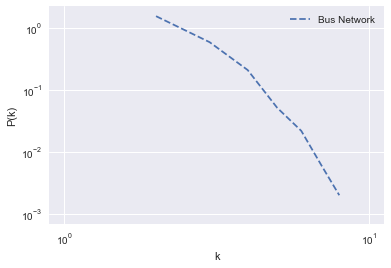

In [209]:
Pk = [float(x) / n for x in nx.degree_histogram(G_bus)]
domain = range(len(Pk))

plt.figure()
plt.loglog(domain, Pk, '--', label = 'Bus Network')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()
plt.show()

We omit values 0 and 1 for the degree since we do not have any node with that characteristics and it difficults the task of identify the curve parameters.

a=1.798, b=2.819


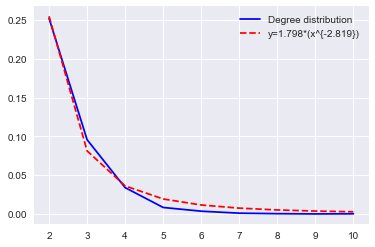

In [210]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def func(x, a, b):
    return a *(x**(-b))

xdata = np.arange(2,11)
y = distdegree[2:]
np.random.seed(1729)
#y_noise = 0.0002 * np.random.normal(size=xdata.size)
ydata = y
popt, pcov = curve_fit(func, xdata, ydata)
print('a=%5.3f, b=%5.3f' % tuple(popt))
      
      
plt.plot(xdata, ydata, 'b-', label='Degree distribution')
plt.plot(xdata,func(xdata, *popt), '--',color='red',label='y=1.798*(x^{-2.819})')
plt.legend(loc='upper right')

In [211]:
print(nx.info(G_bus))

Name: 
Type: Graph
Number of nodes: 2469
Number of edges: 3127
Average degree:   2.5330


### Clustering

#### Triangles

In [212]:
node_triangles_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_triangles_bus.append(nx.triangles(g)) 

#   
#print("Triangles per connected component: {}".format(node_triangles_bus))
#print("Average diameter in bus network: {}".format(np.mean(node_triangles_bus)))

In [213]:
component_node_triangles_bus=[]
bus_stops_coords_lngs_node_triangles_bus1=[]
bus_stops_coords_lats_node_triangles_bus1=[]
bus_stops_coords_lngs_node_triangles_bus2=[]
bus_stops_coords_lats_node_triangles_bus2=[]
bus_stops_coords_lngs_node_triangles_bus3=[]
bus_stops_coords_lats_node_triangles_bus3=[]
compt=0
for i in node_triangles_bus[0]:
    try:
        if list(node_triangles_bus[0].values())[compt]==1:
            bus_stops_coords_lngs_node_triangles_bus1.append(float(bus_stations_properties[i]['lon']))
            bus_stops_coords_lats_node_triangles_bus1.append(float(bus_stations_properties[i]['lat']))
        elif list(node_triangles_bus[0].values())[compt]==2:
            bus_stops_coords_lngs_node_triangles_bus2.append(float(bus_stations_properties[i]['lon']))
            bus_stops_coords_lats_node_triangles_bus2.append(float(bus_stations_properties[i]['lat']))
        elif list(node_triangles_bus[0].values())[compt]==3:
            bus_stops_coords_lngs_node_triangles_bus3.append(float(bus_stations_properties[i]['lon']))
            bus_stops_coords_lats_node_triangles_bus3.append(float(bus_stations_properties[i]['lat']))
    except KeyError:
        pass
    compt+=1;

In [214]:
## Plotting the bus stops on a map
map_osm = folium.Map(location=[41.387084, 2.169792], zoom_start=12)

##for the nodes that are triangles 1
for lng, lat in zip(bus_stops_coords_lngs_node_triangles_bus1,
                         bus_stops_coords_lats_node_triangles_bus1):
    folium.Circle([lat, lng], radius=50, color='#00ff2b').add_to(map_osm)

##for the nodes that are triangles 2
for lng, lat in zip(bus_stops_coords_lngs_node_triangles_bus2,
                         bus_stops_coords_lats_node_triangles_bus2):
    folium.Circle([lat, lng], radius=50, color='#0b9422').add_to(map_osm)

##for the nodes that are triangles 3
for lng, lat in zip(bus_stops_coords_lngs_node_triangles_bus3,
                         bus_stops_coords_lats_node_triangles_bus3):
    folium.Circle([lat, lng], radius=50, color='#032709').add_to(map_osm)


#for lng, lat in zip(bus_stops_coords_lngs_component1,
#                         bus_stops_coords_lats_components1):
#    folium.Circle([lat, lng], radius=50, color='#27cc53').add_to(map_osm)
    

#for lng, lat in zip(bus_stops_coords_lngs_component2,
#                         bus_stops_coords_lats_components2):
#    folium.Circle([lat, lng], radius=50, color='#3186cc').add_to(map_osm)
    ##Blue dots is the disconnected component 2
    
#for lng, lat in zip(bus_stops_coords_lngs_component3,
#                         bus_stops_coords_lats_components3):
#    folium.Circle([lat, lng], radius=50,color='#f40101').add_to(map_osm)
    ##Red dots is the disconnected component 3
    
map_osm

In [215]:
triangleCount1 = collections.Counter(list(node_triangles_bus[0].values()))
print('Component 1:',triangleCount1)
triangleCount2 = collections.Counter(list(node_triangles_bus[1].values()))
print('Component 2:',triangleCount2)
triangleCount3 = collections.Counter(list(node_triangles_bus[2].values()))
print('Component 3:',triangleCount3)
#deg, cnt = zip(*degreeCount.items())

Component 1: Counter({0: 2279, 1: 73, 2: 4, 3: 1})
Component 2: Counter({0: 22})
Component 3: Counter({0: 90})


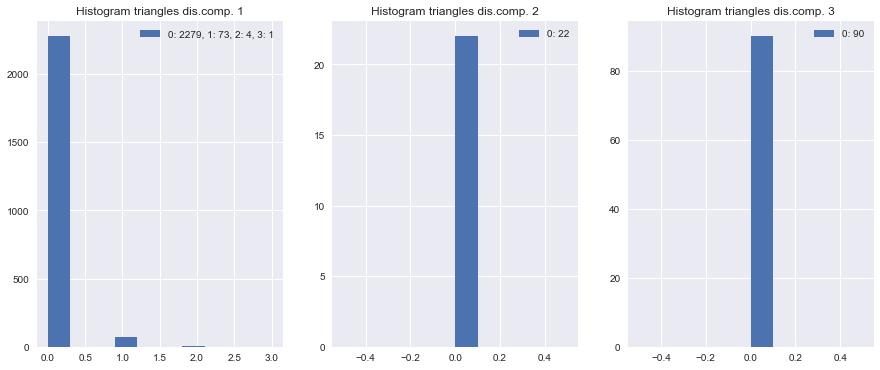

In [216]:
f, axarr = plt.subplots(1, 3,figsize=(15,6))
axarr[0].hist(list(node_triangles_bus[0].values()),label='0: 2279, 1: 73, 2: 4, 3: 1')
axarr[1].hist(list(node_triangles_bus[1].values()),label='0: 22')
axarr[2].hist(list(node_triangles_bus[2].values()),label='0: 90')
axarr[0].set_title('Histogram triangles dis.comp. 1')
axarr[1].set_title('Histogram triangles dis.comp. 2')
axarr[2].set_title('Histogram triangles dis.comp. 3')
axarr[0].legend(loc='upper right')
axarr[1].legend(loc='upper right')
axarr[2].legend(loc='upper right')
plt.show()

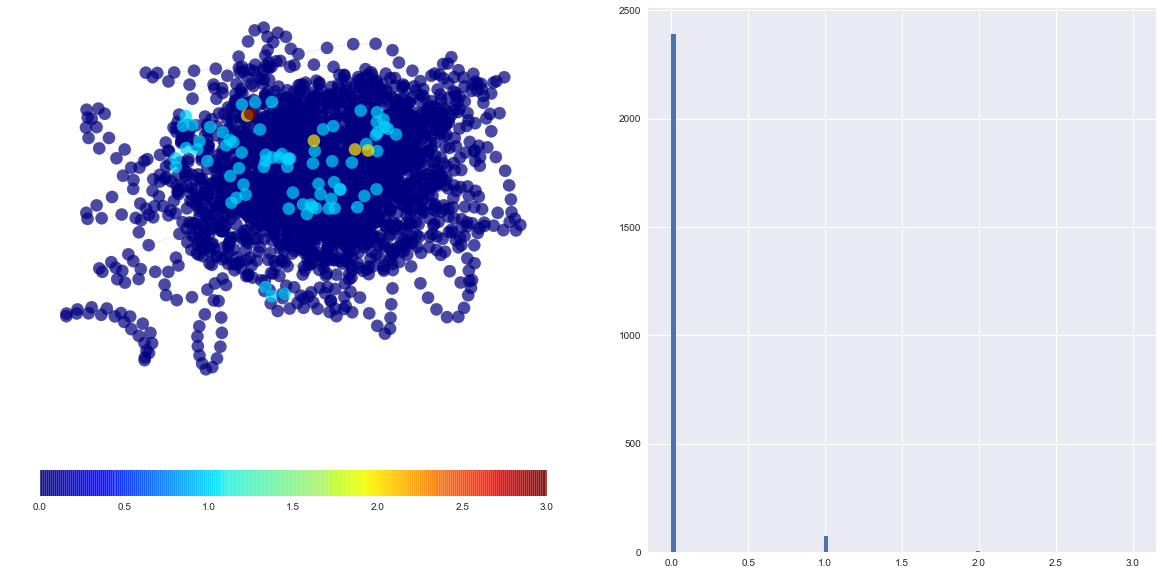

In [217]:
node_triangles_bus=nx.triangles(G_bus)
pos = nx.spring_layout(G_bus)
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.axis('off')
nx.draw_networkx_edges(G_bus, pos=pos, edge_color='#c1c1c1', alpha=.3)
scores = dict(node_triangles_bus)
nodelist = sorted(G_bus.nodes(), key=lambda n: scores[n])
ncolor = np.asarray([scores[n] for n in nodelist])
nodes = nx.draw_networkx_nodes(G_bus, nodelist=nodelist, pos=pos, node_size=150, cmap=plt.cm.jet, node_color=ncolor, alpha=0.7)
plt.colorbar(nodes, cmap=plt.cm.jet, orientation='horizontal')

plt.subplot(122)
score_array = np.array(list(scores.values()))
plt.hist(score_array,bins=100)
plt.show()

#### Clustering

Compute the clustering coefficient for nodes. For unweighted graphs, such our case ,the clustering of a node $i$ is the fraction of possible triangles through that node that exist,

$$C_{i}=\frac{\# \text{triangles connected to i}}{\# \text{possible triangles connected to i}}=\frac{2 E_{i}}{k_{i}(k_{i}-1)}$$

In [218]:
node_clustering_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_clustering_bus.append(nx.clustering(g)) 

   
# 
#print("Triangles per connected component: {}".format(node_clustering_bus))

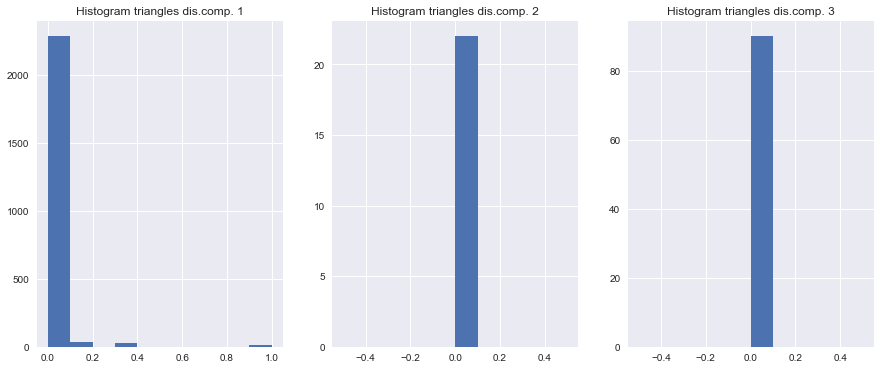

In [219]:
f, axarr = plt.subplots(1, 3,figsize=(15,6))
axarr[0].hist(list(node_clustering_bus[0].values()))
axarr[1].hist(list(node_clustering_bus[1].values()))
axarr[2].hist(list(node_clustering_bus[2].values()))
axarr[0].set_title('Histogram triangles dis.comp. 1')
axarr[1].set_title('Histogram triangles dis.comp. 2')
axarr[2].set_title('Histogram triangles dis.comp. 3')
plt.show()

In [220]:
node_clustering_bus=nx.clustering(G_bus)

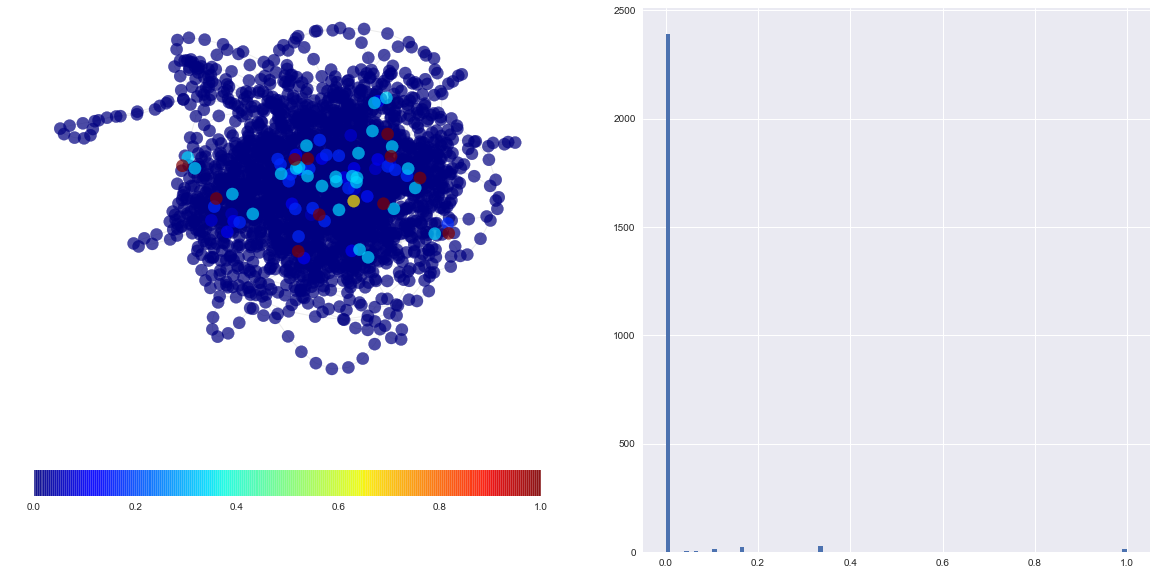

In [221]:
pos = nx.spring_layout(G_bus)
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.axis('off')
nx.draw_networkx_edges(G_bus, pos=pos, edge_color='#c1c1c1', alpha=.3)
scores = dict(node_clustering_bus)
nodelist = sorted(G_bus.nodes(), key=lambda n: scores[n])
ncolor = np.asarray([scores[n] for n in nodelist])
nodes = nx.draw_networkx_nodes(G_bus, nodelist=nodelist, pos=pos, node_size=150, cmap=plt.cm.jet, node_color=ncolor, alpha=0.7)
plt.colorbar(nodes, cmap=plt.cm.jet, orientation='horizontal')

plt.subplot(122)
score_array = np.array(list(scores.values()))
plt.hist(score_array,bins=100)
plt.show()

#### Average Clustering

Compute the average clustering coefficient for the graph G. The clustering coefficient for the graph is the average:

$$C=\frac{1}{n} \sum_{v \in G}c_{v}$$

In [222]:
node_average_clustering_bus=nx.average_clustering(G_bus)

In [223]:
node_average_clustering_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_average_clustering_bus.append(nx.average_clustering(g)) 

   
print("Average clustering per connected component: {}".format(node_average_clustering_bus))

Average clustering per connected component: [0.010891569186011271, 0.0, 0.0]


In [224]:
# To be sent:
    # Number nodes: 2469
    # Number links: 3127
    # Grado medio: 2.5330

#  --------- Others --------- 

## Community Detection

In [225]:
communities_generator = community.girvan_newman(G_bus)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
parts = sorted(map(sorted, next_level_communities))

KeyboardInterrupt: 

In [ ]:
node_communities = [0]*len(nodes)
for idx,c in enumerate(parts):
    for n in c:
        node_communities[nodes.index(n)] = idx
     

In [ ]:
plotNetwork(G_bus,node_communities)

In [ ]:
help(community)

#### degree-degree scatter plo

Each dot represents one directed edge in the network. It can be seen that most edges connect low-degree nodes to each other, with some edges connecting low-degree and high-degree nodes, but it is quite rare that high-degree nodes are connected to each other. Therefore, there is a mild negative degree correlation in this case.

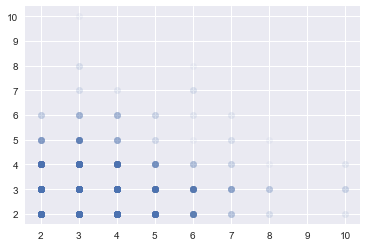

In [226]:
from pylab import *
import networkx as nx
n = 1000
ba = G_bus
xdata = []
ydata = []
for i, j in ba.edges():
    xdata.append(ba.degree(i)); ydata.append(ba.degree(j))
    #xdata.append(ba.degree(j)); ydata.append(ba.degree(i))
plot(xdata, ydata, 'o', alpha = 0.05)
plt.show()

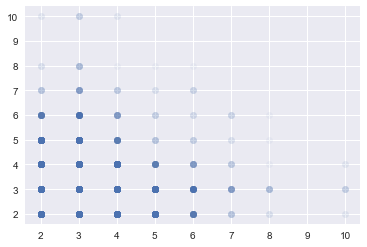

In [227]:
from pylab import *
import networkx as nx
n = 1000
ba = G_bus
xdata = []
ydata = []
for i, j in ba.edges():
    xdata.append(ba.degree(i)); ydata.append(ba.degree(j))
    xdata.append(ba.degree(j)); ydata.append(ba.degree(i))
plot(xdata, ydata, 'o', alpha = 0.05)
plt.show()

#### Assortativity

In [228]:
node_assortativity_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_assortativity_bus.append(nx.degree_pearson_correlation_coefficient(g))

node_assortativity_bus

[0.14105372358145282, 0.23333333333333317, 0.27694090382387021]